In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

from core.dataloader import TimeSeries
from core.model import Hierarchy
from transformer import senticnet

plt.style.use('ggplot')

In [2]:
stock = '0005.HK'
cols = ['Date', 'pos', 'neu', 'neg', 'ple', 'att', 'sen',
        'apt', 'Volume', 'ma10', 'ptc_chg', 'rsi12', 'macd', 'mfi']
data = TimeSeries('data/%s.csv' % stock, usecols=cols)
data.X.head()

,Volume,ptc_chg,ma10,macd,rsi12,mfi,pos,neu,neg,ple,att,sen,apt
Date,,,,,,,,,,,,,
2003-02-20,7353100,0.295858,83.325,0.759016,57.903600,57.627018,8.937750,0.728325,-7.690750,-0.4335,3.785750,4.003000,2.103750
2003-02-21,6683300,-0.884956,83.525,0.690103,50.669253,62.543837,7.526000,0.738739,-8.060000,-0.4450,2.816000,-0.114000,0.005000
2003-02-24,4111600,0.297619,83.675,0.642172,52.813047,61.652685,9.191167,0.777198,-5.029500,0.9650,5.123000,2.002500,4.645833
2003-02-25,5688700,-0.890208,83.800,0.544623,46.237002,60.909202,10.047000,0.745623,-4.093333,3.5270,7.784333,2.176667,4.771333
2003-02-26,4008100,-0.299401,83.850,0.451756,44.234151,64.534873,5.242250,0.795604,-6.427500,-0.9045,2.874000,2.942250,-1.630750


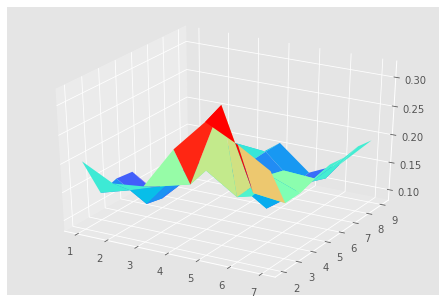

(5, 3)

In [3]:
taus = np.arange(1, 8)
n_class = np.arange(2, 10)

score = []
for tau in taus:
    score_ = []
    for n in n_class:
        X = data.weekly(senticnet,tau)[0]
        X = StandardScaler().fit_transform(X)
        clster = Hierarchy(n, method='ward', criterion='maxclust').fit(X)
        score_.append(clster.silhouette_score_)
    score.append(score_)
score = np.array(score).T
fig = plt.figure()
ax = Axes3D(fig)
grid = np.meshgrid(taus, n_class)
ax.plot_surface(grid[0], grid[1], score, rstride=1, cstride=1, cmap='rainbow')
plt.show()
(taus[np.argmax(score) % len(taus)], n_class[np.argmax(score) // len(taus)])

In [4]:
def class_change(X, y, center, radius, rank=1):
    change = abs(np.sign(np.append(0, np.diff(y,rank)))) # change[0] === 0
    dist = []
    for i in range(len(change)):
        if change[i] == 0:
            dist.append(0)
        else:
            precenter = center[y[i-rank]]
            preradius = radius[y[i-rank]]
            dist.append(abs((np.linalg.norm(X[i] - precenter) - preradius) / preradius))
    return dist

风格的变换有没有周期性：风格自身的周期研究，离散ACD

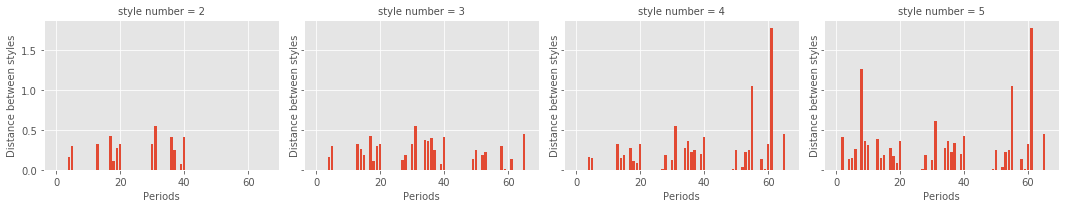

In [5]:
tau = 4
n_class = np.arange(2,6)

X = data.weekly(senticnet,tau)[0]
X = StandardScaler().fit_transform(X)
fig, ax = plt.subplots(1, 4, figsize=(15, 3), sharey=True)
for i, n in enumerate(n_class):
    cluster = Hierarchy(n, method='ward', criterion='maxclust').fit(X)
    dist = class_change(X, cluster.predict(), cluster.center, cluster.radius)
    # dist = [abs(np.linalg.norm(X[i+1] - X[i])) for i in range(len(X)-1)]
    ax[i].bar(np.arange(len(dist)), dist)
    ax[i].set_xlabel('Periods', fontsize=10)
    ax[i].set_ylabel('Distance between styles', fontsize=10)
    ax[i].set_title('Style number = %d' % n, color=(.3,.3,.3), fontsize=10)
plt.tight_layout()
plt.show()

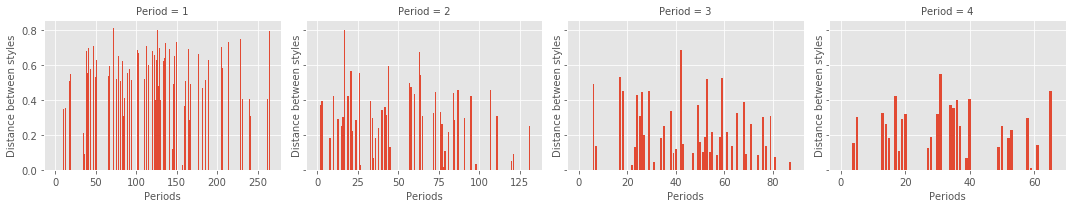

In [12]:
taus = np.arange(1,5)
n = 3

fig, ax = plt.subplots(1, 4, figsize=(15, 3), sharey=True)
for i, tau in enumerate(taus):
    X = data.weekly(senticnet,tau)[0]
    X = StandardScaler().fit_transform(X)
    cluster = Hierarchy(n, method='ward', criterion='maxclust').fit(X)
    dist = class_change(X, cluster.predict(), cluster.center, cluster.radius)
    # dist = [abs(np.linalg.norm(X[i+1] - X[i])) for i in range(len(X)-1)]
    ax[i].bar(np.arange(len(dist)), dist)
    ax[i].set_xlabel('Periods', fontsize=10)
    ax[i].set_ylabel('Distance between styles', fontsize=10)
    ax[i].set_title('Period = %d' % tau, color=(.3,.3,.3), fontsize=10)
plt.tight_layout()
plt.show()

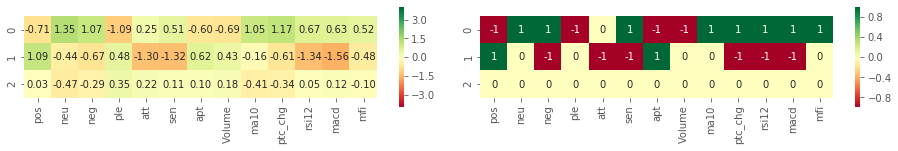

In [6]:
tau, n = 4, 3
threshold = 0.5

X = data.weekly(senticnet,tau)[0]
X = StandardScaler().fit_transform(X)

cluster = Hierarchy(n, method='ward', criterion='maxclust').fit(X)
center = cluster.center
fig, ax = plt.subplots(1, 2, figsize=(13, 2))
ax[0] = sns.heatmap(center,-4, 4, annot=True, square=True, cmap='RdYlGn', fmt='.2f', xticklabels=cols[1:], ax=ax[0])
ax[0].tick_params(labelsize=10)
ax[0].set_ylim(3, 0)
# take the sign of each center.
for i in range(center.shape[0]):
    for j in range(center.shape[1]):
        center[i,j] = np.sign(center[i,j]) if abs(center[i,j]) > threshold else 0
ax[1] = sns.heatmap(center,-1, 1, annot=True, square=True, cmap='RdYlGn', fmt='.0f', xticklabels=cols[1:], ax=ax[1])
ax[1].tick_params(labelsize=10)
ax[1].set_ylim(3, 0)
plt.tight_layout()
plt.show()